# Stroke sensor Health Control data cleaning

#### Data extraction code modified from CIS-PD: DataPreprocessor2_wTime.ipynb
#### https://github.com/adai2017/CIS_PD/blob/master/DataPreprocessor2_wTime.ipynb

# Import packages

In [2]:
# Importing the Libraries
import os
import platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle
from itertools import product
from scipy.stats import skew, kurtosis, pearsonr
from scipy.signal import butter, welch, filtfilt, resample
import time
import re
import copy
%matplotlib inline

In [ ]:
#-- For interactive plots--
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

In [3]:
#---Pandas version required to load pickle files is 0.20.1 or greater---
pd.__version__

'0.23.4'

# Set paths

In [3]:
# if platform.system() == 'Windows':
#     if platform.release() == '7':
path = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\controls'
folder_path = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data'
dict_path = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\Data_dict'
        
#        scores_path = r'X:\CIS-PD Study\Scores'
#        features_path = r'X:\CIS-PD Study\FeatureMatrix'
#else:
#    path = '/Volumes/RTO/CIS-PD Study/Subjects/' #Mac
#    folder_path = '/Volumes/RTO/CIS-PD Study/'
#    dict_path = '../Data_dict' # Mac local path
#    scores_path = '../Scores/' # Mac local path
#    features_path = '../FeatureMatrix' # Mac local path


# Extract Data Functions

In [4]:
# List based on Value data of Activity Recognition
#    Placed in extract_data())
complete= list(['LYING','SITTING','STANDING','WALKING','STAIRS DOWN','STAIRS UP'])

In [5]:
def process_annotations(path):
    """
    Processes raw annotations file to extract start / end timestamps and remove unnecessary data
    Inputs:  path - filepath of the subject folder containing annotations.csv
    Outputs: df - dataframe containing list of activities and their start / end timestamps
    """
    df = pd.read_csv(os.path.join(path, 'annotations.csv'))
    del df['Timestamp (ms)']
    del df['AnnotationId']
    del df['AuthorId']
    
    # subset Activity Recognition data by partially match EventType string
    df = df[df['EventType'].str.match('Activity')]
    del df['EventType']
    df.Value = df.Value.shift(-1)
    df = df.dropna()
    
    # Create Trial column for Value
    sorter = set(df.Value.unique().flatten())
    sorterIndex = dict(zip(sorter, range(len(sorter))))        
    df['Value_Rank'] = df['Value'].map(sorterIndex)
    df['Trial'] = df.groupby('Value')['Start Timestamp (ms)'].rank(ascending=True).astype(int)
    del df['Value_Rank']
    df = df.reset_index(drop=True).set_index('Value')
    
    return df

def extract_data(SubID, path):
    """
    For a given subject, extracts and separates accelerometer, gyroscope, and 
    EMG/ECG data into trials and sensor per activity
    """
    ## This is the annotations.csv dataset cleaned
    ## Used to match timestamp ranges to the accel, gyro, elec data
    timestamps = process_annotations(path)
#    timestamps = fix_errors(SubID, timestamps)
#    timestamps = add_unstruct_data(timestamps)
    
    # Creates list of sensor locations from folders within subject's raw data directory
    locations = [locs for locs in os.listdir(path) if os.path.isdir(os.path.join(path, locs))]
    
    # Creates dictionary of empty dataframes to merge all accelerometer, gyroscope, and EMG/ECG data for each sensor
    accel = {locs: pd.DataFrame() for locs in locations}
    gyro = {locs: pd.DataFrame() for locs in locations}
    elec = {locs: pd.DataFrame() for locs in locations}
    
    # Finds and merges all accelerometer, gyroscope, and EMG/ECG data for each sensor, retains datetime information
    for root, dirs, files in os.walk(path, topdown=True):
        for filenames in files:
            if filenames.endswith('accel.csv'):
                p = pathlib.Path(os.path.join(root, filenames))
                location = str(p.relative_to(path)).split("\\")[0]
                temp_df = pd.read_csv(p).set_index('Timestamp (ms)')
                accel[location] = accel[location].append(temp_df)

            elif filenames.endswith('gyro.csv'):
                p = pathlib.Path(os.path.join(root, filenames))
                location = str(p.relative_to(path)).split("\\")[0]
                temp_df = pd.read_csv(p).set_index('Timestamp (ms)')
                gyro[location] = gyro[location].append(temp_df)

            elif filenames.endswith('elec.csv'):
                p = pathlib.Path(os.path.join(root, filenames))
                location = str(p.relative_to(path)).split("\\")[0]
                temp_df = pd.read_csv(p).set_index('Timestamp (ms)')
                elec[location] = elec[location].append(temp_df)
                
    # List based on Value data of Activity Recognition
    complete= list(['LYING','SITTING','STANDING','WALKING','STAIRS DOWN','STAIRS UP'])
    complete_acts = complete
    
    # Complete dictionary of all activities
    act_dict = {acts: pd.DataFrame() for acts in complete_acts}
    
    # Populate dictionary keys per activity with every iteration / trial
    for activities in complete_acts:
        
        startSize = timestamps.loc[activities, 'Start Timestamp (ms)']
        
        if np.size(startSize) == 1:
            startTimestamp = timestamps.loc[activities, 'Start Timestamp (ms)']
            endTimestamp = timestamps.loc[activities, 'Stop Timestamp (ms)']
        else:
            startTimestamp = timestamps.loc[activities, 'Start Timestamp (ms)'].values
            endTimestamp = timestamps.loc[activities, 'Stop Timestamp (ms)'].values

        # Create trial dictionary with each key containing all sensor data related with each activity's trial
        trial_dict = {trials: pd.DataFrame() for trials in range(0, np.size(startTimestamp))}

        # Populate trial directory keys
        for trials in range(0, np.size(startTimestamp)):

            if np.size(startSize) == 1:
                startTime = startTimestamp
                endTime = endTimestamp
            else:
                startTime = startTimestamp[trials]
                endTime = endTimestamp[trials]

            # Create sensor location dictionary with each key corresponding to sensor locations
            sensor_dict = {locs: pd.DataFrame() for locs in locations}

            # Extract sensor data and populate sensor_dict with sensor data
            for location in locations:

                data = {'accel': pd.DataFrame(), 'gyro': pd.DataFrame(), 'elec': pd.DataFrame()}

                if not accel[location].empty:
                    accelData = accel[location]
                    data['accel'] = accelData[(accelData.index >= startTime) & (accelData.index <= endTime)]  
 
                if not gyro[location].empty:
                    gyroData = gyro[location]
                    data['gyro'] = gyroData[(gyroData.index >= startTime) & (gyroData.index <= endTime)]
                   
                if not elec[location].empty:
                    elecData = elec[location]
                    data['elec'] = elecData[(elecData.index >= startTime) & (elecData.index <= endTime)]
                   
                sensor_dict[location] = data

            trial_dict[trials] = sensor_dict

        act_dict[activities] = trial_dict
    
    return act_dict, timestamps

def unstack_ar_dictionary(act_dict):
    """Takes a 4-level nested dictionary and unstacks into a activity recognition dataframe."""
    df = pd.DataFrame([(k1, k2, k3, k4, v) for k1, k234v in act_dict.items()
                           for k2, k34v in k234v.items()
                           for k3, k4v in k34v.items()
                           for k4, v in k4v.items()])
    df.columns = ['task','trial','location','sensor','rawdata']
    return df

def extract_date_from_timestamp(timestamp):
    """Convert UNIX to Timestamp data type and cleanup timestamp dataframe
    Input: Dataframe with timestamp annotations in UNIX time in milliseconds
    Output: Dataframe with tasks
    """
    timestamp.reset_index(inplace=True)
    timestamp.insert(1,'date',pd.to_datetime(timestamp['Start Timestamp (ms)'], unit='ms'))
    timestamp.drop(timestamp.columns[[2,3]], inplace=True, axis=1)
    # adjust trial number to start from 0
    timestamp.Trial = timestamp.Trial - 1
    # keep date only in date column
    timestamp.date = timestamp.date.dt.date
    # rename columns
    timestamp.rename(index=str, columns={'Value':'task', 'Trial':'trial'}, inplace=True)
    
    return timestamp


In [ ]:
#def gen_unimodal_data(input_dict, side, unimodal_acts=None, shift=50):

In [ ]:
#def add_unstruct_data(input_timestamp):

## Extract function for graphs - nested dictionary and clipping

In [ ]:
def subj_accel_data(act_dict,task,location):
    
    merged_data = pd.DataFrame()
    
    for trial in act_dict[task].keys():
        
        for s in ['accel']:
            rawdata = act_dict[task][trial][location][s]
            
            #reindex time (relative to start)
            idx = rawdata.index
            if merged_data.empty is True:
                idx = idx - idx[0]
            else:
                idx = idx - idx[0] + 32 + merged_data.index[-1]
            rawdata.index = idx
            
            #append subsequent trial data
            merged_data = merged_data.append(rawdata)
    
    
    return merged_data

In [ ]:
# Test HC02 with functions to merge trials

#load Pickle file dict
subj = 'HC02'
f = open(os.path.join(dict_path, subj + 'dict.pkl'), 'rb')
act_dict = pickle.load(f)
f.close()

# test function for HC02 walking sacrum accel data
test1 = subj_accel_data(act_dict,'WALKING',location='sacrum')

# merged trials vs non-merged trials
test1.plot(figsize=(8,4))
rawdata.plot(figsize=(8,4))

In [ ]:
def subj_gyro_data(act_dict,task,location):
    
    merged_data = pd.DataFrame()
    
    for trial in act_dict[task].keys():
        
        for s in ['gyro']:
            rawdata = act_dict[task][trial][location][s]
            
            #reindex time (relative to start)
            idx = rawdata.index
            if merged_data.empty is True:
                idx = idx - idx[0]
            else:
                idx = idx - idx[0] + 32 + merged_data.index[-1]
            rawdata.index = idx
            
            #append subsequent trial data
            merged_data = merged_data.append(rawdata)
    
    
    return merged_data

In [ ]:
## Luca's function from previous PD study

#extract clips for accelerometer and gyro data (allows selecting start and end fraction)
#lentol is the % of the intended clipsize below which clip is not used
def gen_clips(act_dict,task,location,clipsize=5000,overlap=0,verbose=False,startTS=0,endTS=1,len_tol=0.8,resample=False):

    clip_data = {} #the dictionary with clips

    for trial in act_dict[task].keys():
        clip_data[trial] = {}

        for s in ['accel','gyro']:

            if verbose:
                print(task,' sensortype = %s - trial %d'%(s,trial))
            #create clips and store in a list
            rawdata = act_dict[task][trial][location][s]
            if rawdata.empty is True: #skip if no data for current sensor
                continue
            #reindex time (relative to start)
            idx = rawdata.index
            idx = idx-idx[0]
            rawdata.index = idx
            #choose to create clips only on a fraction of the data (0<[startTS,endTS]<1)
            if (startTS > 0) | (endTS < 1):
                rawdata = rawdata.iloc[round(startTS*len(rawdata)):round(endTS*len(rawdata)),:]
                #reindex time (relative to start)
                idx = rawdata.index
                idx = idx-idx[0]
                rawdata.index = idx
            #create clips data
            deltat = np.median(np.diff(rawdata.index))
            clips = []
            #use entire recording
            if clipsize == 0:
                clips.append(rawdata)
            #take clips
            else:
                idx = np.arange(0,rawdata.index[-1],clipsize*(1-overlap))
                for i in idx:
                    c = rawdata[(rawdata.index>=i) & (rawdata.index<i+clipsize)]
                    if len(c) > len_tol*int(clipsize/deltat): #discard clips whose length is less than len_tol% of the window size
                        clips.append(c)

            #store clip length
            clip_len = [clips[c].index[-1]-clips[c].index[0] for c in range(len(clips))] #store the length of each clip
            #assemble in dict
            clip_data[trial][s] = {'data':clips, 'clip_len':clip_len}

    return clip_data

# Testing

## 1. Test HC03 and see if data is similar to HC02 in missing data for 13 sensors

In [7]:
SubID = 'HC03'
act_dict, timestamps = extract_data(SubID, os.path.join(path, SubID))

In [10]:
unstacked = unstack_ar_dictionary(act_dict)

In [11]:
timestamps

,Start Timestamp (ms),Stop Timestamp (ms),Trial
Value,,,
LYING,1510866952700,1510867012883,1
SITTING,1510867046108,1510867106433,1
STANDING,1510867138114,1510867169089,1
SIT TO STAND,1510867241126,1510867249430,1
WALKING,1510867311946,1510867369415,1
STANDING,1510867402779,1510867433145,2
STAIRS DOWN,1510867477434,1510867487647,1
STAIRS UP,1510867523414,1510867533970,1
STANDING,1510867559336,1510867589710,3


In [13]:
unstacked.loc[unstacked.sensor=='accel']

,task,trial,location,sensor,rawdata
0,LYING,0,biceps_femoris_left,accel,Accel X (g) Accel Y (g) Acce...
3,LYING,0,biceps_femoris_right,accel,Accel X (g) Accel Y (g) Acce...
6,LYING,0,bicep_left,accel,Accel X (g) Accel Y (g) Acce...
9,LYING,0,bicep_right,accel,Accel X (g) Accel Y (g) Acce...
12,LYING,0,distal_lateral_shank_left,accel,Accel X (g) Accel Y (g) Acce...
15,LYING,0,distal_lateral_shank_right,accel,Accel X (g) Accel Y (g) Acce...
18,LYING,0,gastrocnemius_left,accel,Accel X (g) Accel Y (g) Acce...
21,LYING,0,gastrocnemius_right,accel,Accel X (g) Accel Y (g) Acce...
24,LYING,0,medial_chest,accel,Accel X (g) Accel Y (g) Acce...
27,LYING,0,posterior_forearm_left,accel,Accel X (g) Accel Y (g) Acce...


In [19]:
bicepcheck = unstacked.query('sensor == "accel" & location == "bicep_left" & task == "LYING"')

In [20]:
bicepcheck

,task,trial,location,sensor,rawdata
6,LYING,0,bicep_left,accel,Accel X (g) Accel Y (g) Acce...
54,LYING,1,bicep_left,accel,Accel X (g) Accel Y (g) Acce...


In [23]:
bicepcheck.rawdata[54].head(3)

,Accel X (g),Accel Y (g),Accel Z (g)
Timestamp (ms),,,
1510868001422,-0.243595,-0.275822,0.975174
1510868001454,-0.240665,-0.271427,0.968338
1510868001486,-0.247501,-0.270451,0.966873


In [25]:
checkempty = unstacked.query('sensor == "accel" & location == "sacrum" ')

In [26]:
checkempty

,task,trial,location,sensor,rawdata
39,LYING,0,sacrum,accel,Accel X (g) Accel Y (g) Acce...
87,LYING,1,sacrum,accel,Accel X (g) Accel Y (g) Acce...
135,SITTING,0,sacrum,accel,Accel X (g) Accel Y (g) Acce...
183,SITTING,1,sacrum,accel,Accel X (g) Accel Y (g) Acce...
231,SITTING,2,sacrum,accel,Accel X (g) Accel Y (g) Acce...
279,SITTING,3,sacrum,accel,Accel X (g) Accel Y (g) Acce...
327,STANDING,0,sacrum,accel,Accel X (g) Accel Y (g) Acce...
375,STANDING,1,sacrum,accel,Accel X (g) Accel Y (g) Acce...
423,STANDING,2,sacrum,accel,Accel X (g) Accel Y (g) Acce...
471,STANDING,3,sacrum,accel,Accel X (g) Accel Y (g) Acce...


In [30]:
checkempty[checkempty.rawdata.map(lambda d: len(d)) > 0]

,task,trial,location,sensor,rawdata
39,LYING,0,sacrum,accel,Accel X (g) Accel Y (g) Acce...
87,LYING,1,sacrum,accel,Accel X (g) Accel Y (g) Acce...
135,SITTING,0,sacrum,accel,Accel X (g) Accel Y (g) Acce...
183,SITTING,1,sacrum,accel,Accel X (g) Accel Y (g) Acce...
231,SITTING,2,sacrum,accel,Accel X (g) Accel Y (g) Acce...
279,SITTING,3,sacrum,accel,Accel X (g) Accel Y (g) Acce...
327,STANDING,0,sacrum,accel,Accel X (g) Accel Y (g) Acce...
375,STANDING,1,sacrum,accel,Accel X (g) Accel Y (g) Acce...
423,STANDING,2,sacrum,accel,Accel X (g) Accel Y (g) Acce...
471,STANDING,3,sacrum,accel,Accel X (g) Accel Y (g) Acce...


In [46]:
len(checkempty)
# none are empty

22

## 2. PASS - Test timestamp annotations with date for feature matrix

In [8]:
SubID = 'HC02'
path = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\controls'
path_hc02 = os.path.join(path, SubID)
timestamp =process_annotations(path_hc02)
timestamp_with_date = extract_date_from_timestamp(timestamp)

In [10]:
timestamp.head(2)

,task,date,trial
0,LYING,2017-11-13,0
1,SITTING,2017-11-13,0


In [11]:
timestamp_with_date.head(2)

,task,date,trial
0,LYING,2017-11-13,0
1,SITTING,2017-11-13,0


# Create dictionaries from sensor data from all the subjects

In [13]:
print(os.listdir(dict_path))
print(len(os.listdir(dict_path)))

['HC01dict.pkl', 'HC02dict.pkl', 'HC03dict.pkl', 'HC04dict.pkl', 'HC05dict.pkl', 'HC06dict.pkl', 'HC07dict.pkl', 'HC08dict.pkl', 'HC09dict.pkl', 'HC10dict.pkl', 'HC11dict.pkl', 'HC12dict.pkl', 'HC13dict.pkl', 'HC14dict.pkl', 'HC15dict.pkl', 'HC16dict.pkl', 'HC17dict.pkl', 'HC18dict.pkl', 'HC19dict.pkl', 'HC20dict.pkl', 'HC21dict.pkl', 'HC22dict.pkl', 'HC23dict.pkl', 'HC24dict.pkl', 'HC25dict.pkl', 'HC26dict.pkl', 'HC27dict.pkl', 'HC28dict.pkl', 'HC29dict.pkl', 'HC30dict.pkl', 'HC31dict.pkl', 'HC32dict.pkl', 'HC33dict.pkl', 'HC34dict.pkl', 'HC35dict.pkl', 'HC36dict.pkl', 'HC39dict.pkl', 'HC40dict.pkl', 'HC41dict.pkl', 'HC42dict.pkl', 'HC43dict.pkl', 'HC44dict.pkl', 'HC45dict.pkl', 'HC46dict.pkl', 'HC47dict.pkl', 'HC48dict.pkl', 'HC49dict.pkl', 'HC50dict.pkl', 'HC51dict.pkl', 'mas', 'old_annotations_HC37and38', 'test']
52


In [14]:
# Rerun if more subject data added
# If list returns empty, no need to update

#all subj data files in repository
d = os.listdir(path)
f = [filename[0:4] for filename in d if filename.startswith('HC')]
#skip existing data dictionary files in ../biostamp_data/Data_dict
fd = os.listdir(dict_path)
fd = [x[:4] for x in fd]
print(list(set(f) - set(fd)))

['HC37', 'HC38']


In [15]:
#create data dict for remaining subjects
data_all = []

for SubID in list(set(f) - set(fd)):
    print('Loading Subject ' + SubID + ' Data...')
    act_dict, timestamps = extract_data(SubID, os.path.join(path, SubID))
    print('Extract data complete.')
    
    #save dict to Pickle file
    filename = os.path.join(dict_path, SubID + 'dict.pkl')
    #filename = SubID + 'dict.pkl' # will need to move to Y: drive
    with open(filename,'wb') as f:
        pickle.dump(act_dict,f)
    print(filename + ' ' + 'File Saved\n')

Loading Subject HC37 Data...
Extract data complete.
//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\Data_dict\HC37dict.pkl File Saved

Loading Subject HC38 Data...
Extract data complete.
//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\Data_dict\HC38dict.pkl File Saved



# Change? - Load pickle files in C: and create new files in Y: drive
- change C: to Y: for dict_path2

In [56]:
## open, load, create new file in Y: directory

dict_path2 = r'C:\Users\lu-rt&o\Documents\GitHub\activity-recognition-process'
dict_path3 = r'Y:\Inpatient Sensors -Stroke\Data\biostamp_data\Data_dict'

#list subjects in db
d = os.listdir(dict_path2)
all_f = [filename[:4] for filename in d if filename.startswith('H')]
print(np.sort(all_f))


['HC01' 'HC02' 'HC03' 'HC04' 'HC05' 'HC06' 'HC07' 'HC08' 'HC09' 'HC10'
 'HC11' 'HC12' 'HC13' 'HC14' 'HC15' 'HC16' 'HC17' 'HC18' 'HC19' 'HC20'
 'HC21' 'HC22' 'HC23' 'HC24' 'HC25' 'HC26' 'HC27' 'HC28' 'HC29' 'HC30'
 'HC31' 'HC32' 'HC33']


In [58]:
#load Pickle file dict
for subj in all_f:
    subj_filename = str(subj) + 'dict.pkl'
    #f = open(os.path.join(dict_path2, subj_filename), 'rb')
    #act_dict = pickle.load(f)
    #f.close()
    with open(os.path.join(dict_path2, subj_filename), 'rb') as f:
        act_dict = pickle.load(f)
    
    print(subj_filename)
    
    # create new pickle file in path3
    #f2 = open(os.path.join(dict_path3, subj_filename),'wb')
    #pickle.dump(act_dict,f2)
    #f2.close()
    with open(os.path.join(dict_path3, subj_filename),'wb') as f2:
        pickle.dump(act_dict,f2)
    print(subj_filename + ' ' + 'File Saved\n')

HC01dict.pkl
HC01dict.pkl File Saved

HC02dict.pkl
HC02dict.pkl File Saved

HC03dict.pkl
HC03dict.pkl File Saved

HC04dict.pkl
HC04dict.pkl File Saved

HC05dict.pkl
HC05dict.pkl File Saved

HC06dict.pkl
HC06dict.pkl File Saved

HC07dict.pkl
HC07dict.pkl File Saved

HC08dict.pkl
HC08dict.pkl File Saved

HC09dict.pkl
HC09dict.pkl File Saved

HC10dict.pkl
HC10dict.pkl File Saved

HC11dict.pkl
HC11dict.pkl File Saved

HC12dict.pkl
HC12dict.pkl File Saved

HC13dict.pkl
HC13dict.pkl File Saved

HC14dict.pkl
HC14dict.pkl File Saved

HC15dict.pkl
HC15dict.pkl File Saved

HC16dict.pkl
HC16dict.pkl File Saved

HC17dict.pkl
HC17dict.pkl File Saved

HC18dict.pkl
HC18dict.pkl File Saved

HC19dict.pkl
HC19dict.pkl File Saved

HC20dict.pkl
HC20dict.pkl File Saved

HC21dict.pkl
HC21dict.pkl File Saved

HC22dict.pkl
HC22dict.pkl File Saved

HC23dict.pkl
HC23dict.pkl File Saved

HC24dict.pkl
HC24dict.pkl File Saved

HC25dict.pkl
HC25dict.pkl File Saved

HC26dict.pkl
HC26dict.pkl File Saved

HC27dict.pkl

In [ ]:
#load Pickle file dict
for subj in all_f:
    subj_filename = str(subj) + 'dict.pkl'
    with open(os.path.join(dict_path2, subj_filename), 'rb') as f:
        act_dict = pickle.load(f)
    
    print(subj_filename)
    
    # create new pickle file in path3
    with open(os.path.join(dict_path3, subj_filename),'wb') as f2:
        pickle.dump(act_dict,f2)
    print(subj_filename + ' ' + 'File Saved\n')

## Explore features from individual subject

In [8]:
# use context manager to reload pickle file
dict_path2 = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\Data_dict'
subj = 'HC02'
filename = os.path.join(dict_path2, subj + 'dict.pkl')
with open(filename,'rb') as filename:
    act_dict = pickle.load(filename)

In [12]:
# test empty example
task = 'LYING'
loc = 'tibialis_anterior_left'
# sensor = 'accel'
sensor = 'gyro'
trial = 0
act_dict[task][trial][loc][sensor]

""


In [10]:
# Choose task, sensor location, data type, and trials

#task = 'LYING'
#task = 'SITTING'
#task = 'STANDING'
task = 'WALKING'
#task = 'STAIRS DOWN'
#task = 'STAIRS UP'

#loc = 'bicep_left'
#loc = 'bicep_right'
#loc = 'biceps_femoris_left'
#loc = 'biceps_femoris_right'
#loc = 'distal_lateral_shank_left' # has accel and gyro
#loc = 'distal_lateral_shank_right' # has accel and gyro
#loc = 'gastrocnemius_left'
#loc = 'gastrocnemius_right'
#loc = 'medial_chest'
#loc = 'posterior_forearm_left'
#loc = 'posterior_forearm_right'
#loc = 'rectus_femoris_left'
#loc = 'rectus_femoris_right'
loc = 'sacrum' # has accel and gyro
#loc = 'tibialis_anterior_left'
#loc = 'tibialis_anterior_right'

## want a + g
sensor = 'accel'
#sensor = 'gyro'
#sensor = 'elec'

trial = 1

In [ ]:
# import copy
# act_dict_copy2 = copy.deepcopy(act_dict)

In [11]:
print(task,loc,sensor,trial)

WALKING sacrum accel 1


In [21]:
rawdata = act_dict[task][trial][loc][sensor]

In [22]:
rawdata.shape

(1605, 3)

In [ ]:
rawdata

### HC02: WALKING sacrum accel 1

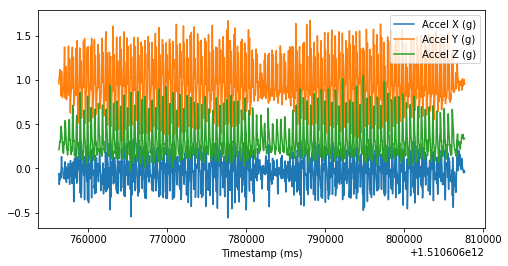

In [14]:
#activity dictionary structure (TASK-TRIAL-LOCATION-SENSOR)
rawdata = act_dict[task][trial][loc][sensor]
#idx = rawdata.index
#idx = idx-idx[0]
#rawdata.index = idx
rawdata.plot(figsize=(8,4))

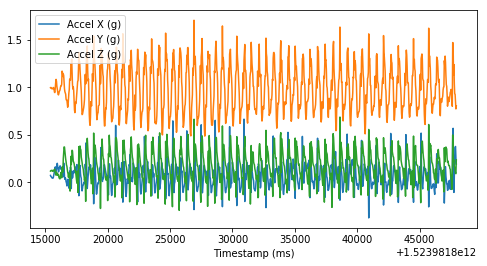

In [64]:
# Sacrum walking
rawdata = act_dict['WALKING'][0]['sacrum']['accel']
rawdata.plot(figsize=(8,4))

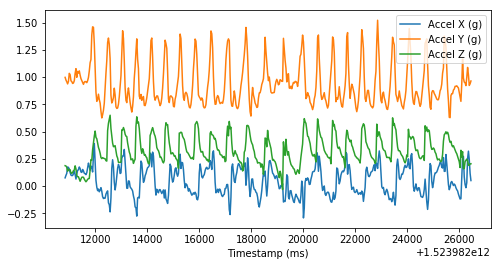

In [60]:
# Sacrum stairs UP
rawdata = act_dict['STAIRS UP'][0]['sacrum']['accel']
rawdata.plot(figsize=(8,4))

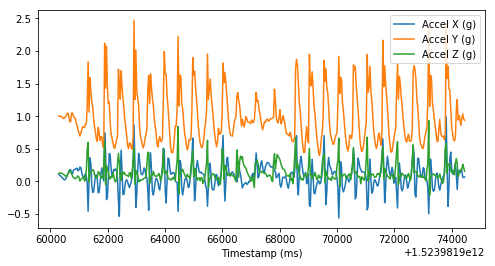

In [61]:
# Sacrum stairs DOWN
rawdata = act_dict['STAIRS DOWN'][0]['sacrum']['accel']
rawdata.plot(figsize=(8,4))

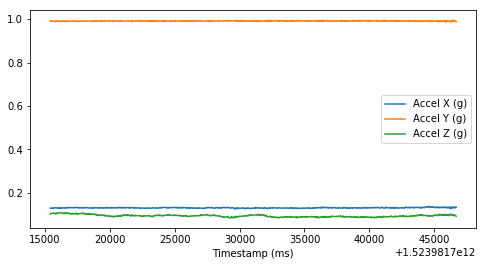

In [62]:
# Sacrum standing
rawdata = act_dict['STANDING'][0]['sacrum']['accel']
rawdata.plot(figsize=(8,4))

### HC02: WALKING left_ankle accel 1

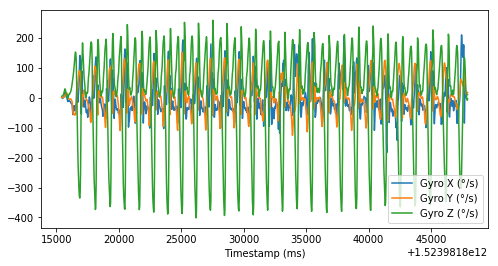

In [65]:
#activity dictionary structure (TASK-TRIAL-LOCATION-SENSOR)
rawdata = act_dict['WALKING'][0]['distal_lateral_shank_left']['gyro']
rawdata.plot(figsize=(8,4))

### HC02: WALKING right_ankle accel 1

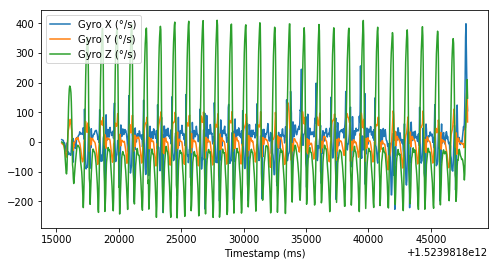

In [66]:
#activity dictionary structure (TASK-TRIAL-LOCATION-SENSOR)
rawdata = act_dict['WALKING'][0]['distal_lateral_shank_right']['gyro']
rawdata.plot(figsize=(8,4))

In [ ]:
np.size((act_dict[task][trial][loc][sensor])

In [ ]:
# np.size(act_dict_copy2[task][trial][loc][sensor])

In [ ]:
#activity dictionary structure (TASK-TRIAL-LOCATION-SENSOR)
act_dict_right = gen_unimodal_data(act_dict, side='left', shift=100)
clip_data = act_dict_right[task][trial][loc][sensor]
idx = clip_data.index
idx = idx-idx[0]
clip_data.index = idx
clip_data.plot(figsize=(8,4))

In [ ]:
np.size(clip_data)

# Misc bin

## Extract clips

In [28]:
# unstack nested dictionary
df = pd.DataFrame([(k1, k2, k3, k4, v) for k1, k234v in act_dict.items()
                           for k2, k34v in k234v.items()
                           for k3, k4v in k34v.items()
                           for k4, v in k4v.items()])
df.columns = ['task','trial','location','sensor','rawdata']

In [30]:
df.head(5)

,task,trial,location,sensor,rawdata
0,LYING,0,bicep_left,accel,Accel X (g) Accel Y (g) Acce...
1,LYING,0,bicep_left,gyro,Empty DataFrame Columns: [] Index: []
2,LYING,0,bicep_left,elec,Sample (V) Timestamp (ms) ...
3,LYING,0,bicep_right,accel,Accel X (g) Accel Y (g) Acce...
4,LYING,0,bicep_right,gyro,Empty DataFrame Columns: [] Index: []


### Extract full recordings

In [ ]:
#clipsize=0 extracts full recordings
clip_data = gen_clips(act_dict,task,loc,clipsize=0,verbose=True)
feature_extraction(clip_data)

In [ ]:
clip_data[0]['accel']['features']

### Extract clips

In [ ]:
clip_data = gen_clips(act_dict,task,loc,verbose=True,len_tol=0.95)
feature_extraction(clip_data)

## Raw sensors data visualization - single subject

In [ ]:
# plot all trials data from either one side or both sides
task = 
loc1 = 'dorsal_hand_left'
loc2 = 'dorsal_hand_right'

#simulating additive or multiplicative noise
loc = 'dorsal_hand_left'
sensor = 'accel'

rawdata=act_dict[task][0][loc][sensor]
# rawdata = rawdata.applymap(lambda x: x+(.3/9.81)*np.random.randn(1)[0]) #additive noise
rawdata = rawdata*1.0*np.random.randn(1)[0]
rawdata.plot()
plt.ylim([-1,2])


idxidx  ==  rawdatarawdata..indexindex
idxidx  ==  idxidx--idxidx[[00]]
rawdatarawdata..indexindex  ==  idxidx
rawdatarawdata..headhead()()
    


In [ ]:
#plot L and R side
trials = act_dict[task].keys() #all available trials
sns.set_context('paper')
p = product([task],trials)
taskslist = list(p)
for t in taskslist:
    fig=plt.figure()
    ax1 = fig.add_subplot(121)
    plot_data(act_dict,t[0],t[1],loc1,'accel',plt_ax=ax1,add_noise=False,start=0,end=20000)
    ax1.set_title(tuple([str(subj)])+tuple([str(t[1])])+tuple([loc1]))
    ax1.set_ylim([-2,2])
    ax2 = fig.add_subplot(122)
    plot_data(act_dict,t[0],t[1],loc2,'accel',plt_ax=ax2,start=0,end=20000)
    ax2.set_title(tuple([str(subj)])+tuple([str(t[1])])+tuple([loc2]))
    ax2.set_ylim([-2,2])

In [ ]:
#plot one side only
sns.set_context('paper')
p = product([task],trials)
taskslist = list(p)
for t in taskslist:
    plot_data(act_dict,t[0],t[1],loc,'accel')
    plt.title(tuple([str(subj)])+t+tuple([loc]))

## Plot raw data from all subjects for a given task and trial

In [ ]:
#choose task, trials(visits) and sensor location
loc1 = 'dorsal_hand_left'
loc2 = 'dorsal_hand_right'
# loc1 = 'flexor_digitorum_left'
# loc2 = 'flexor_digitorum_right'
trial = 5

#list subjects in db
d = os.listdir(path)
all_f = [filename[:4] for filename in d if filename.startswith('H')]
print(np.sort(all_f))

#load Pickle file dict
for subj in all_f:
    #########
    # Use context manager here?
    subj_filename = str(subj) + 'dict.pkl'
    f = open(os.path.join(path, subj_filename), 'rb')
    act_dict = pickle.load(f)
    f.close()
    
    #filter data
    HPfilter(act_dict,task=task,loc=loc1)
    HPfilter(act_dict,task=task,loc=loc2)
    BPfilter(act_dict,task=task,loc=loc1)
    BPfilter(act_dict,task=task,loc=loc2)
    
    fig=plt.figure()
    ax1 = fig.add_subplot(121)
    plot_data(act_dict,task,trial,loc1,'accel',plt_ax=ax1)
    ax1.set_title(tuple([str(subj)])+tuple([str(trial)])+tuple([loc1]))
    ax1.set_ylim([-1,1])
    ax2 = fig.add_subplot(122)
    plot_data(act_dict,task,trial,loc2,'accel',plt_ax=ax2)
    ax2.set_title(tuple([str(subj)])+tuple([str(trial)])+tuple([loc2]))
    ax2.set_ylim([-1,1])